# Testing notebook

I am using this notebooks to test and

* **benchmark** the performance of `xoak.sel` with various degrees of parallellism and multithreads.

All of the datsets **ECCO**, **DYAMOND** and **LLC4320** **are stored and accessed locally**. These datasets all share the same topology, but with different degree of resolution.




In [1]:
import oceanspy as ospy
import matplotlib.pyplot as plt
import numpy as np
from oceanspy.utils import viewer2range

In [2]:
import xoak as _xoak
import dask
import xarray as xr
from oceanspy.utils import circle_path_array

In [25]:
def Xoak_setIndex(DS, Xmoor, Ymoor, xoak_index='scipy_kdtree'):
    import xarray as _xr
    from xarray import DataArray
    import xoak as _xoak
    
    ds_grid = DS[["XC", "YC"]]  # center points
    ds_grid = ds_grid.reset_coords()
    drop_vars = [var for var in ds_grid.data_vars if var not in ['XC', 'YC']]
    ds_grid = ds_grid.drop_vars(drop_vars)
    ds_grid = ds_grid.set_coords(['XC', 'YC'])
    for key, value in ds_grid.sizes.items():
        ds_grid["i" + f"{key}"] = DataArray(range(value), dims=key)
    if xoak_index not in _xoak.IndexRegistry():
        raise ValueError(
            "`xoak_index` [{}] is not supported."
            "\nAvailable options: {}"
            "".format(xoak_index, _xoak.IndexRegistry())
        )
    # set index
    ds_grid.xoak.set_index(["XC", "YC"], xoak_index)
    cdata = {"XC": ("mooring", Xmoor), "YC": ("mooring", Ymoor)}
    ds_data = _xr.Dataset(cdata) # mooring data
    
    return ds_data, ds_grid

# Some parameters

In [27]:
xoak_index = 'scipy_kdtree' # other options for xoak_index. I should consider all of them.

Catalog_url = 'LLC4320_test.yaml'

# Create lazy dataset object

## ECCO

In [30]:
# Directory
ECCOod = ospy.open_oceandataset.from_catalog("ECCO", Catalog_url)
dsECCO = ECCOod._ds
dsECCO

Opening ECCO.


<xarray.Dataset>
Dimensions:    (Xp1: 90, Z: 50, Y: 90, face: 13, time: 1, Yp1: 90, X: 90,
                Zp1: 51, Zu: 50, Zl: 50, time_midp: 0)
Coordinates: (12/41)
  * Xp1        (Xp1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    k          (Z) int64 dask.array<chunksize=(50,), meta=np.ndarray>
  * Y          (Y) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * Z          (Z) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
    timestep   (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    ...         ...
    HFacC      (Z, face, Y, X) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    HFacW      (Z, face, Y, Xp1) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    maskW      (Z, face, Y, Xp1) bool dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    maskC      (Z, face, Y, X) bool dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    maskS      (Z, face, Yp1, X) bool dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
  * time_midp  (time_midp) datetime64[ns] 
Data variables:
    U          (time, Z, face, Y, Xp1) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    V          (time, Z, face, Yp1, X) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    T          (time, Z, face, Y, X) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
Attributes: (12/22)
    product_time_coverage_start:  1992-01-01T12:00:00
    author:                       Ou Wang and Ian Fenty
    Insitution:                   JPL
    product_version:              ECCO Version 4 Release 3 Extension (ECCOv4r...
    time_units:                   days since 1992-01-01 00:00:00
    Conventions:                  CF-1.6
    ...                           ...
    geospatial_vertical_max:      -5.0
    date_created:                 Tue Aug 27 13:39:23 2019
    time_coverage_start:          1992-01-01T00:00:00
    time_coverage_end:            1992-02-01T00:00:00
    OceanSpy_grid_coords:         {'Y': {'Y': None, 'Yp1': -0.5}, 'X': {'X': ...
    OceanSpy_face_connections:    {'face': {0: {'X': ((12, 'Y', False), (3, '...

## DYAMOND

In [31]:
DYAMONDod = ospy.open_oceandataset.from_catalog("DYAMOND", Catalog_url)
dsDYA = DYAMONDod._ds
dsDYA

Opening DYAMOND.
10 day hourly data from the Dyamond computed using the MITGCM, a general, curvilinear ocean simulation on the cube-sphere.


<xarray.Dataset>
Dimensions:    (face: 13, Y: 2160, X: 2160, time: 1, Z: 90, Zp1: 91, Yp1: 2160,
                Xp1: 2160, Zl: 90, Zu: 90, time_midp: 0)
Coordinates: (12/45)
    CS         (face, Y, X) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    Depth      (face, Y, X) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    PHrefC     (Z) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    PHrefF     (Zp1) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    SN         (face, Y, X) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    XC         (face, Y, X) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    ...         ...
    rSurfC     (face, Y, X) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    rSurfS     (face, Yp1, X) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    rSurfW     (face, Y, Xp1) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    rhoRef     (Z) float32 dask.array<chunksize=(90,), meta=np.ndarray>
  * time       (time) datetime64[ns] 2011-01-17
  * time_midp  (time_midp) datetime64[ns] 
Data variables:
    Eta        (time, face, Y, X) float32 dask.array<chunksize=(1, 1, 2160, 2160), meta=np.ndarray>
Attributes:
    OceanSpy_parameters:        {'rSphere': 6371.0, 'eq_state': 'jmd95', 'rho...
    OceanSpy_name:              LLC4320
    OceanSpy_description:       10 day hourly data from the Dyamond computed ...
    OceanSpy_grid_coords:       {'Y': {'Y': None, 'Yp1': -0.5}, 'X': {'X': No...
    OceanSpy_face_connections:  {'face': {0: {'X': ((12, 'Y', False), (3, 'X'...

## LLC4320

In [32]:
LLC4320od = ospy.open_oceandataset.from_catalog("LLC4320", Catalog_url)
dsLLC4320 = LLC4320od._ds
dsLLC4320

Opening LLC4320.
10 day hourly data from the LLC4320 simulations computed using the MITGCM, a general, curvilinear ocean simulation on the cube-sphere.


<xarray.Dataset>
Dimensions:    (face: 13, Y: 4320, X: 4320, time: 1, Yp1: 4320, Xp1: 4320,
                time_midp: 0)
Coordinates: (12/27)
    CS         (face, Y, X) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth      (face, Y, X) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN         (face, Y, X) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC         (face, Y, X) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG         (face, Yp1, Xp1) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC         (face, Y, X) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    ...         ...
    rA         (face, Y, X) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs        (face, Yp1, X) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw        (face, Y, Xp1) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz        (face, Yp1, Xp1) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
  * time       (time) datetime64[ns] 2011-09-13
  * time_midp  (time_midp) datetime64[ns] 
Data variables:
    Eta        (time, face, Y, X) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
Attributes:
    OceanSpy_parameters:        {'rSphere': 6371.0, 'eq_state': 'jmd95', 'rho...
    OceanSpy_name:              LLC4320
    OceanSpy_description:       10 day hourly data from the LLC4320 simulatio...
    OceanSpy_grid_coords:       {'Y': {'Y': None, 'Yp1': -0.5}, 'X': {'X': No...
    OceanSpy_face_connections:  {'face': {0: {'X': ((12, 'Y', False), (3, 'X'...

# Sampling Data

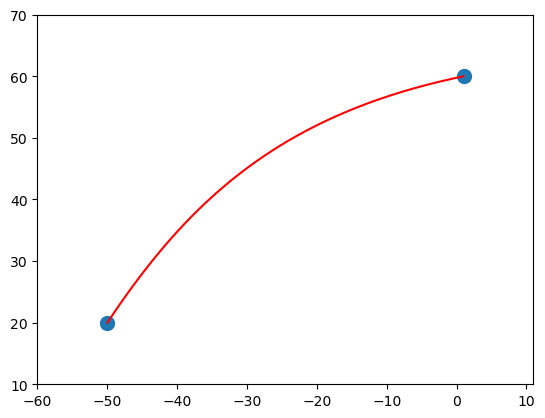

In [8]:
# Data across 2 faces

Xmoor1 = np.array([-50, 1])
Ymoor1 = np.array([20, 60])

Ymoor, Xmoor = circle_path_array(Ymoor1, Xmoor1, R)

plt.plot(Xmoor1, Ymoor1, ls='',marker='o', markersize=10)
plt.plot(Xmoor, Ymoor, 'r')
plt.xlim(np.min(Xmoor1)-10, np.max(Xmoor1)+10)
plt.ylim(np.min(Ymoor1)-10, np.max(Ymoor1)+10)
plt.show()

# Pick a dataset

In [9]:
ECCO_time = %timeit -o -r 10 -n 2 Xoak_setIndex(dsECCO, Xmoor, Ymoor)

25.2 ms ± 5.06 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)


In [10]:
Dyamond_time = %timeit -o -r 10 -n 10 Xoak_setIndex(dsDYA, Xmoor, Ymoor)

4.3 s ± 103 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [10]:
LLC4320_time = %timeit -o -r 10 -n 2 Xoak_setIndex(dsLLC4320, Xmoor, Ymoor)

19.6 s ± 422 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)


## check slowest build, with different degrees of parallellism

# serially

## Begin with DYAMOND since faster


In [17]:
with dask.config.set(scheduler='single-threaded'):
     %timeit -o -r 10 -n 2 Xoak_setIndex(dsDYA, Xmoor, Ymoor)

16.4 s ± 56 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)


In [22]:
with dask.config.set(scheduler='processes', nworkers=2):
     %timeit -o -r 10 -n 2 Xoak_setIndex(dsDYA, Xmoor, Ymoor)

19 s ± 266 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)


In [24]:
with dask.config.set(scheduler='threads', nworkers=8):
     %timeit -o -r 10 -n 2 Xoak_setIndex(dsDYA, Xmoor, Ymoor)

3.8 s ± 185 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)


In [ ]:
## LLC4320

In [34]:
with dask.config.set(scheduler='threads', nworkers=8):
     %timeit -o -r 10 -n 2 Xoak_setIndex(dsLLC4320, Xmoor, Ymoor)

#  Data Selection

Each dataset has a different size, and so the number of points queried and extracted differs across dataset.


## LLC4320

In [13]:
DS, DS_grid =  XoakDS(dsLLC4320, Xmoor, Ymoor)

In [14]:
%timeit -o -r 10 -n 2 DS_grid.xoak.sel(XC=DS["XC"], YC=DS["YC"])

27.1 ms ± 16.5 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)


<TimeitResult : 27.1 ms ± 16.5 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)>